# UNet Inference Notebook

> This notebook is used to make predictions on the given dataset using the trained UNet model.

In [1]:
#| default_exp unet_inference

In [2]:
#| export
import torch 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
import os 
from torchvision import transforms
import matplotlib.pyplot as plt
import torch


In [3]:
#| export
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
#| export
class WenmaSet(Dataset):
    def __init__(self, data_path, data_type, transform=None):
        self.data_path = data_path
        self.data_type = data_type
        self.transform = transform

        if (
            self.data_type == "train"
            or self.data_type == "val"
            or self.data_type == "unlabeled"
        ):
            self.num_frames = 22

        else:
            self.num_frames = 11

    def __getitem__(self, ind):
        images = []
        masks = []

        if "train" in self.data_type:
            ind = ind

        elif "val" in self.data_type:
            ind = ind + 1000

        elif "unlabeled" in self.data_type:
            ind = ind + 2000

        elif "hidden" in self.data_type:
            ind = ind + 15000

        video_path = os.path.join(self.data_path, "video_{}".format(ind))

        if "hidden" in self.data_type or "unlabeled" in self.data_type:
            mask_path = None

        else:
            mask_path = os.path.join(video_path, "mask.npy")

        for frame in range(self.num_frames):
            image_path = os.path.join(video_path, "image_{}.png".format(frame))
            image = np.array(Image.open(image_path))
            if self.transform:
                image = self.transform(image)
            images.append(image)
            if mask_path != None:
                if "prediction" in self.data_type:
                    mask = np.load(mask_path)[frame + 11]
                else:
                    mask = np.load(mask_path)[frame]
            else:
                mask = torch.zeros((160, 240))
            masks.append(mask)

        return images, masks

    def __len__(self):
        return len(os.listdir(self.data_path))

In [5]:
#| export
DEFAULT_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),           
    transforms.Resize((160, 240)),          
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
           
])

In [6]:
#| export
@torch.no_grad()
def get_inference(model, image):
    """
    This function expects image to be a tensor of shape (1, 3, 160, 240)
    Also, it should be transformed using the DEFAULT_TRANSFORM.
    """
    model.eval()
    pred = model(image)
    return torch.argmax(pred, dim=1).detach().cpu()

# Tests

In [7]:
%cd ..

/home/enes/dev/maskpredformer


/home/enes/miniforge3/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [8]:
pred_val_masks = torch.load('data/DL/val_masks.pt')

In [9]:
model = torch.jit.load('checkpoints/unet9.pt').to(device)

In [10]:
data_path = "data/Dataset_Student/"
data_type = "val"

dataset= WenmaSet(data_path = data_path + data_type,
                  data_type = data_type,
                  transform = DEFAULT_TRANSFORM)

In [11]:
imgs, masks = dataset[0]

In [12]:
mask_predictions = []
for i in range(22):
    image = imgs[i].unsqueeze(0).to(device)
    pred = get_inference(model, image) 
    mask_predictions.append(pred)

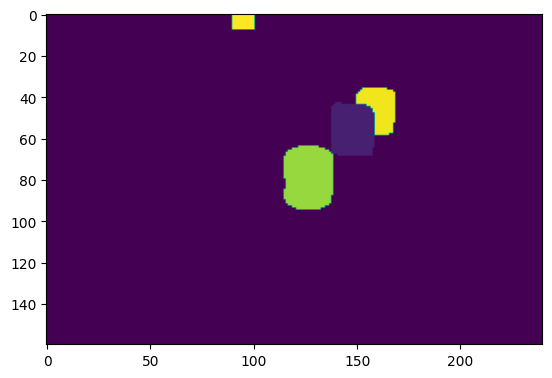

In [13]:
plt.imshow(mask_predictions[10][0])

In [14]:
torch.allclose(mask_predictions[10][0], pred_val_masks[0][10].long())

True